In [1]:
from kitaev import *
from tqdm import tqdm
from functools import reduce

#t=1
N_global = 150
d_global = 4
delta = 0.50*t


def onsite(t=t, mu=mu, B=B, delta=delta):
    return  - mu * np.kron(s_z,s_0) + B * np.kron(s_z,s_z) 


def hopping(t=t, alpha=a, delta = delta):
    return -t * np.kron(s_z,s_0) + 0.5 * 1j * alpha * np.kron(s_z,s_x) + delta * 1j * np.kron(s_y,s_0)

t = 1.0
p1 = {'t':1 * t, 'mu': 0 * t, 'B':0 * t, 'delta':1 * t, 'alpha':0 * t}
p2 = {'t':0 * t, 'mu': 1 * t, 'B':0 * t, 'delta':0 * t, 'alpha':0 * t}
p3 = {'t':0 * t, 'mu': 0 * t, 'B':1 * t, 'delta':0 * t, 'alpha':0 * t}
p4 = {'t':0 * t, 'mu': 0 * t, 'B':0 * t, 'delta':0 * t, 'alpha':1 * t}




h_1 = Hamiltonian(d_global,N_global,onsite(t = p1['t'],mu=p1['mu'],B=p1['B'],delta=p1['delta']),hopping(t=p1['t'],alpha=p1['alpha'],delta=p1['delta']))
h_2 = Hamiltonian(d_global,N_global,onsite(t = p2['t'],mu=p2['mu'],B=p2['B'],delta=p2['delta']),hopping(t=p2['t'],alpha=p2['alpha'], delta=p2['delta']))
h_3 = Hamiltonian(d_global,N_global,onsite(t = p3['t'],mu=p3['mu'],B=p3['B'],delta=p3['delta']),hopping(t=p3['t'],alpha=p3['alpha'], delta=p3['delta']))
h_4 = Hamiltonian(d_global,N_global,onsite(t = p4['t'],mu=p4['mu'],B=p4['B'],delta=p4['delta']),hopping(t=p4['t'],alpha=p4['alpha'], delta=p4['delta']))
hamiltonians = [h_1.lattice_hamiltonian(), h_2.lattice_hamiltonian(), h_3.lattice_hamiltonian(), h_4.lattice_hamiltonian()]





var_T = np.linspace(0.01*np.pi, 8*np.pi, 101)


G_0_odd = []
G_0_even = []
G_pi_odd = []
G_pi_even = []

delta_amount =  1E-7
delta_positive_0 = (delta_amount * 1j) #* np.eye(N_global * d_global)
delta_negative_0 = (-delta_amount * 1j) #* np.eye(N_global * d_global)
delta_positive_pi = (1 - delta_amount * 1j) #* np.eye(N_global * d_global)
delta_negative_pi = (1 + delta_amount * 1j) #* np.eye(N_global * d_global)

delta_positive_pi_2 = 0  +(-1 - delta_amount * 1j) #* np.eye(N_global * d_global)
delta_negative_pi_2 = 0  +(-1 + delta_amount * 1j) #* np.eye(N_global * d_global)


def one_period_propagator(hamiltonians, T, n=None):  # TODO: Return this to work in the general case
    if isinstance(hamiltonians, list):
        n = len(hamiltonians)
    elif callable(hamiltonians):
        hamiltonians = [hamiltonians(i * (T / n)) for i in range(n)]
    exps = []
    for h in hamiltonians:
        eval, evec = la.eigh(h)
        exps.append(evec @ np.diag(np.exp(eval * (-1j * T/n)) ) @ np.conj(evec.transpose()))
    #exps = [sla.expm(-1j * h * T / n) for h in hamiltonians] #very slow
    return reduce(np.matmul,exps)


def floquet_hamiltonian(hamiltonians, T, n=None):
    u_T = one_period_propagator(hamiltonians, T, n)
    eigenval, eigenvec = la.eig(u_T)
    #h_f1 = eigenvec @ np.diag(np.log(eigenval) * 1j / np.pi) @ np.conj(eigenvec.transpose())
    return (np.log(eigenval) * 1j / np.pi) , eigenvec


energiesv2 = []
for j in tqdm(range(len(var_T))):
    eval, evec = floquet_hamiltonian(hamiltonians, T=var_T[j])
    #print(np.isclose(evec @ evec.conj().T, np.eye(d_global*N_global),atol=1e-8,rtol=1e-5))
    #print("\n")
    #np.testing.assert_allclose(evec @ evec.conj().T, np.eye(d_global*N_global),atol=1e-8,rtol=1e-5)
    

    eval = eval.real
    energiesv2.append(np.sort([(-1) ** n * val for n, val in enumerate(np.sort(np.abs(eval)))]))
    evec_inv = la.inv(evec)
    #h_f = (h_f + np.conj(h_f.T))/2 
    G_0_pos = np.diag(1/(delta_positive_0 - eval))
    G_0_neg = np.diag(1/(delta_negative_0 - eval))

    G_0_odd.append(evec @ (G_0_pos - G_0_neg) @ evec_inv / 2)
    G_0_even.append(evec @ (G_0_pos + G_0_neg) @ evec_inv / 2)

    G_pi_pos = np.diag(1/(delta_positive_pi - eval) + 1/(delta_positive_pi_2 - eval))
    G_pi_neg = np.diag(1/(delta_negative_pi - eval) + 1/(delta_negative_pi_2 - eval))
    G_pi_odd.append(evec @ (G_pi_pos - G_pi_neg) @ evec_inv / 4)
    G_pi_even.append(evec @ (G_pi_pos + G_pi_neg) @ evec_inv / 4)

    
    pass


hi


100%|██████████| 101/101 [04:35<00:00,  2.73s/it]


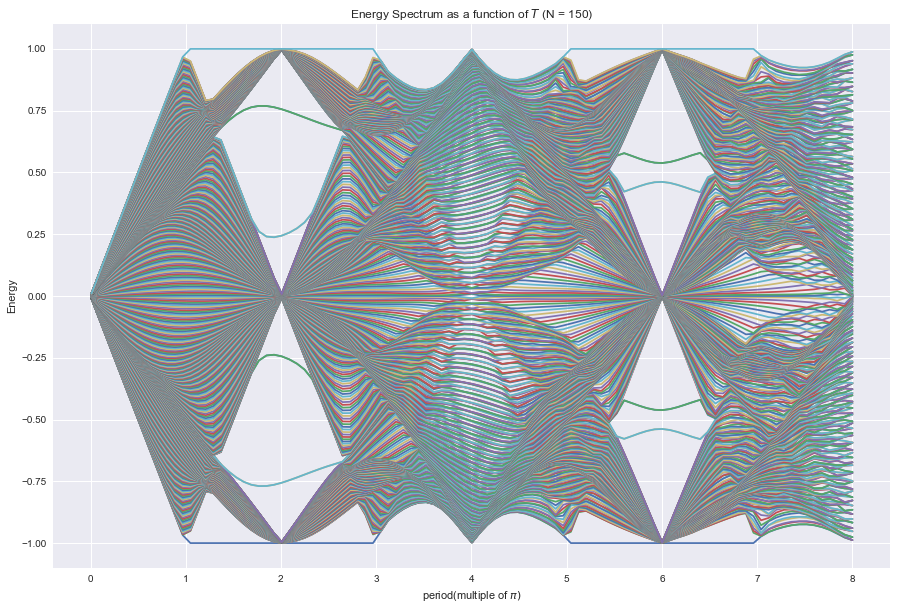

In [73]:

#energies = calculate_finite_spectrum(var_T, [h_1.lattice_hamiltonian(), h_2.lattice_hamiltonian()])
energiesv2 = np.array(energiesv2)
plt.title(f"Energy Spectrum as a function of $T$ (N = {N_global})")
for i in range(4*N_global):
    #plt.plot(var_T,energies[:,i]/np.pi)
    plt.plot(var_T/np.pi,energiesv2[:,i])
plt.ylabel('Energy')
plt.xlabel('period(multiple of $\pi)$')
#plt.axhline(6/13)
#plt.axhline(7/13)
#plt.axhline(1/4)
#plt.axhline(3/4)
#plt.axhline(2/5)

plt.show()


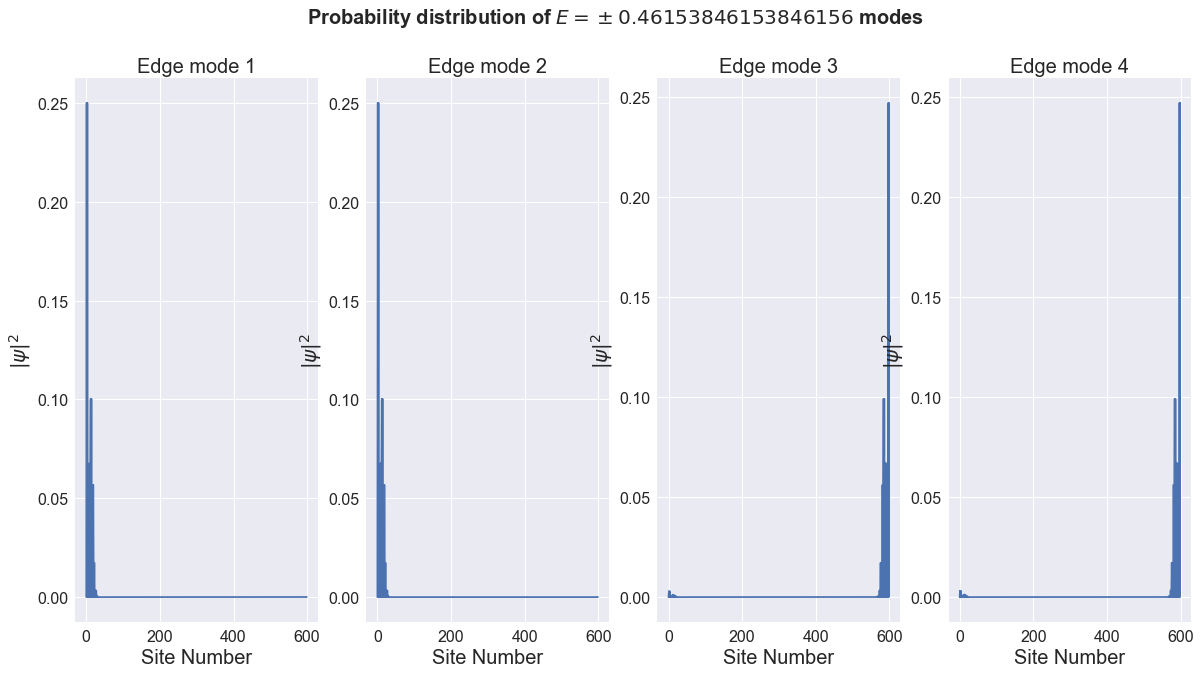

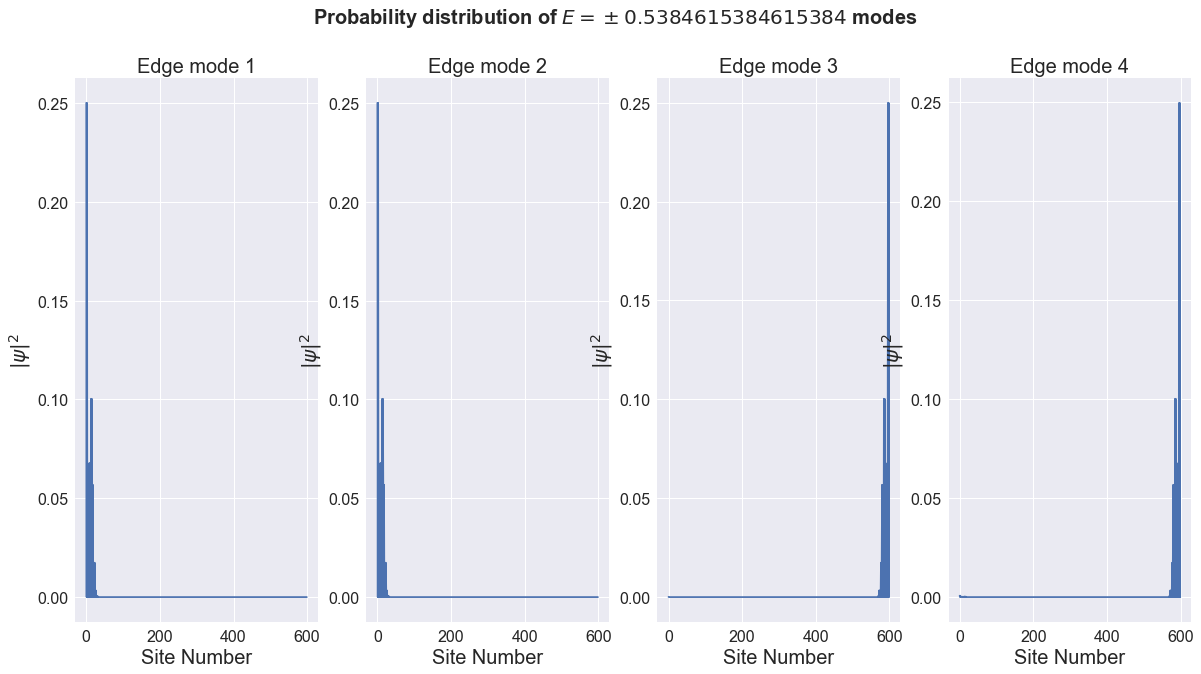

In [57]:
hamiltonians = [h_1.lattice_hamiltonian(), h_2.lattice_hamiltonian(), h_3.lattice_hamiltonian(), h_4.lattice_hamiltonian()]
eval, evec = floquet_hamiltonian(hamiltonians, T= 6*np.pi)
#eval, evec = floquet_hamiltonian([h1, h2], T=var_T[25])
smol = 1E-3
#zero_modes = plot_modes(eval,evec,0,e_threshold=smol)
#pi_modes = plot_modes(eval,evec,1, e_threshold=smol)
#half_pi_modes = plot_modes(eval,evec,0.5, e_threshold=smol)
#quarter_pi_modes = plot_modes(eval,evec,0.25, e_threshold=smol)
#three_quarter_pi_modes = plot_modes(eval,evec,0.75, e_threshold=smol)
#third_pi_modes = plot_modes(eval,evec,1/3, e_threshold=smol)
#two_third_pi_modes = plot_modes(eval,evec,2/3, e_threshold=smol)
six_over_thirteen_pi_modes = plot_modes(eval,evec,6/13, e_threshold=smol)
seven_over_thirteen_pi_modes = plot_modes(eval,evec,7/13, e_threshold=smol)


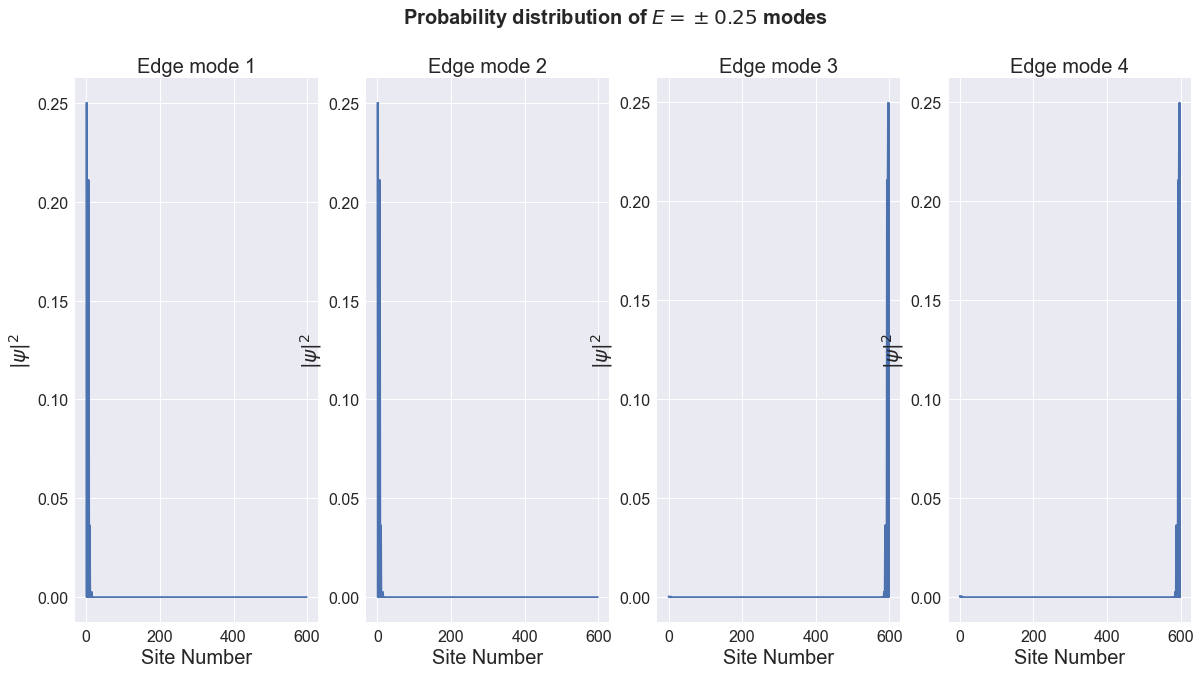

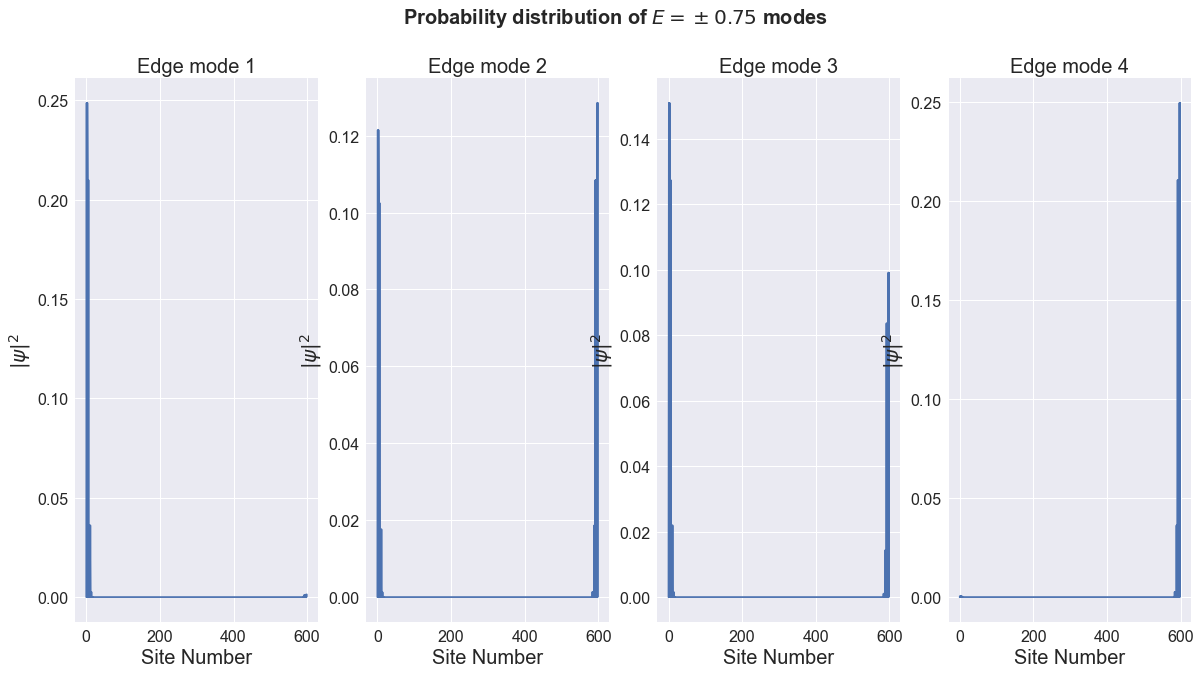

In [68]:
eval, evec = floquet_hamiltonian(hamiltonians, T= 2*np.pi)
smol = 1E-1
half_pi_modes = plot_modes(eval,evec,0.5, e_threshold=smol)
quarter_pi_modes = plot_modes(eval,evec,0.25, e_threshold=smol)
three_quarter_pi_modes = plot_modes(eval,evec,0.75, e_threshold=smol)
#third_pi_modes = plot_modes(eval,evec,1/3, e_threshold=smol)
#two_third_pi_modes = plot_modes(eval,evec,2/3, e_threshold=smol)


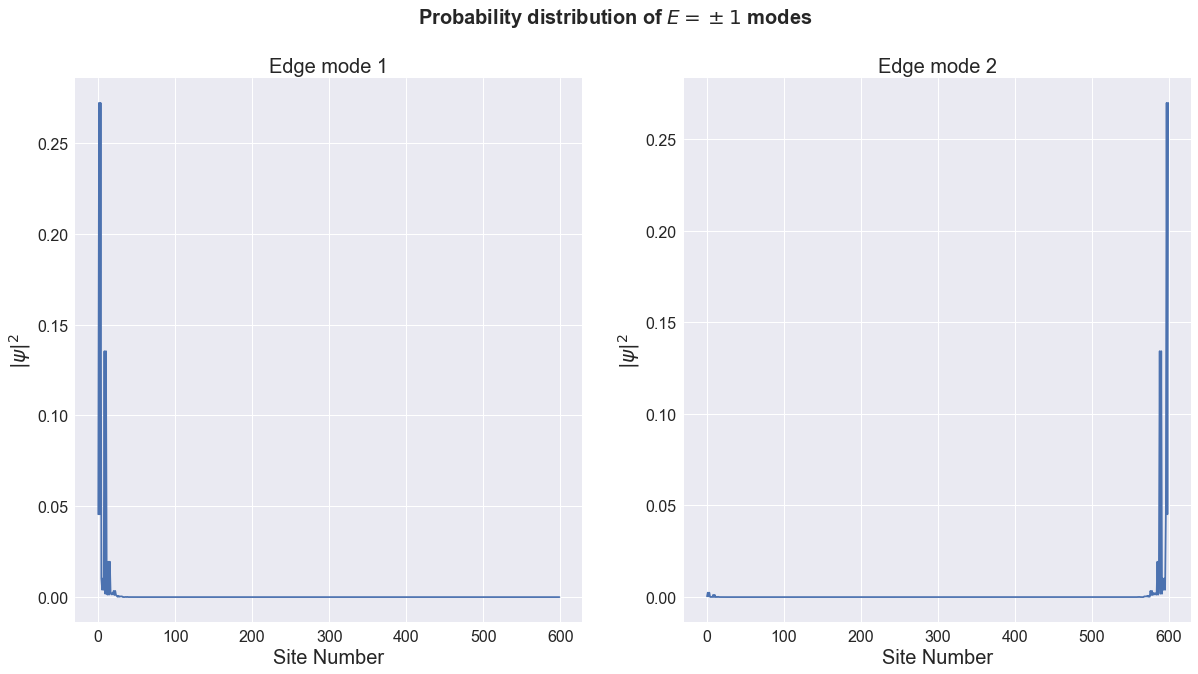

In [72]:
eval, evec = floquet_hamiltonian(hamiltonians, T= 1.5*np.pi)
#eval, evec = floquet_hamiltonian([h1, h2], T=var_T[25])
smol = 1E-3
zero_modes = plot_modes(eval,evec,0,e_threshold=smol)
pi_modes = plot_modes(eval,evec,1, e_threshold=smol)


In [64]:
print(eval[six_over_thirteen_pi_modes].real)
from fractions import Fraction
print(Fraction(f'{eval[six_over_thirteen_pi_modes[0]].real}'))
print(Fraction('0.46185824'))
print(2309291202447833/5000000000000000)
print(1443307/3125000)

[ 0.46185824 -0.46185824 -0.46185824  0.46185824]
2309291202447833/5000000000000000
1443307/3125000
0.4618582404895666
0.46185824


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


101


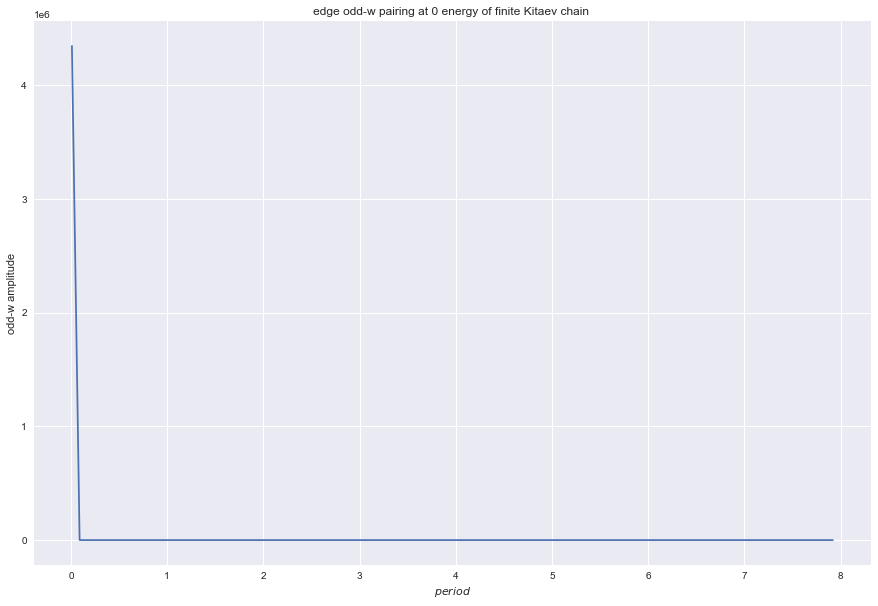

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


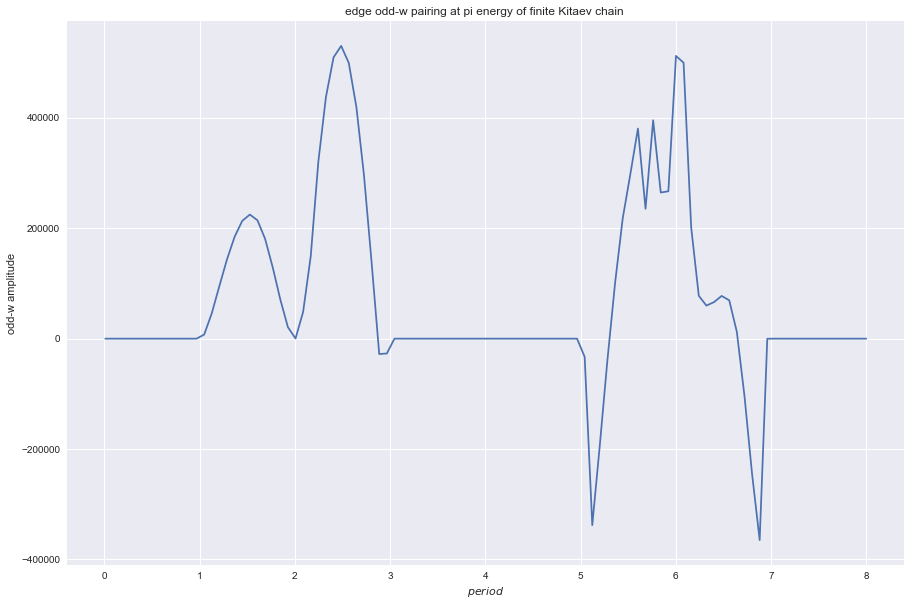

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


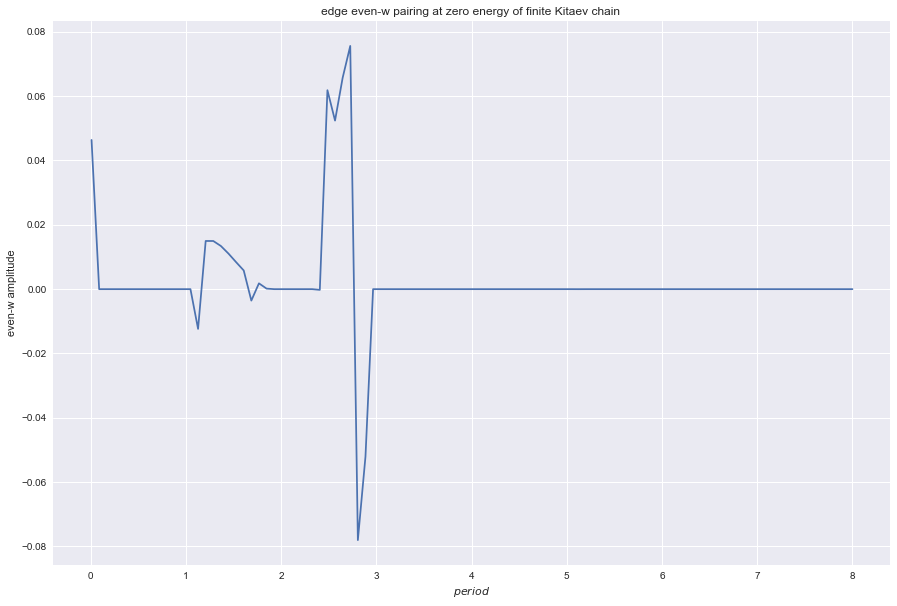

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


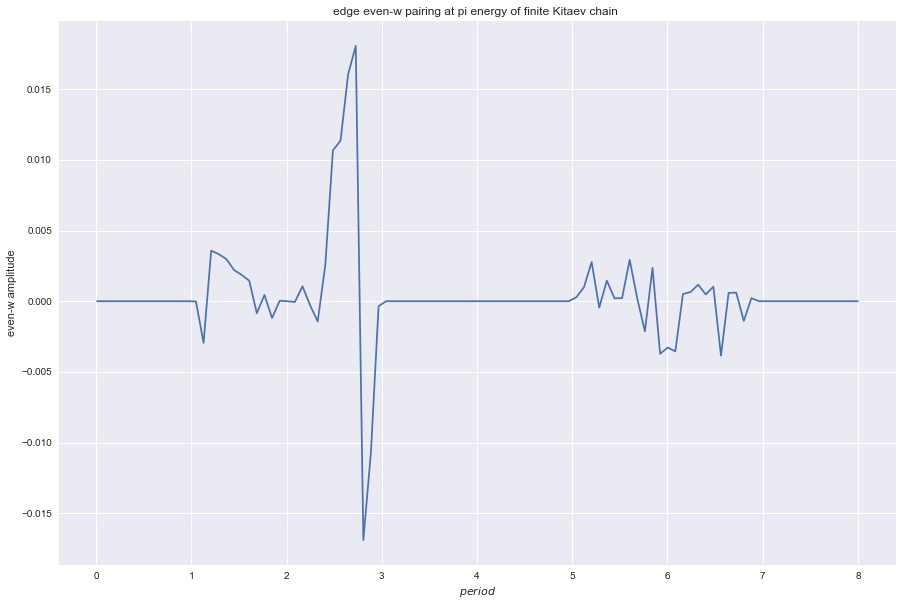

In [3]:
f_0_odd = [(G_0_odd[i][0, 2].imag) for i in range(len(G_0_odd))]
f_0_even = [(G_0_even[i][0, 2].imag) for i in range(len(G_0_even))]
f_pi_odd = [(G_pi_odd[i][0, 2].imag) for i in range(len(G_pi_odd))]
f_pi_even = [(G_pi_even[i][0, 2].imag) for i in range(len(G_pi_even))]


var_T = var_T/np.pi
print(len(G_0_odd))
plt.title("edge odd-w pairing at 0 energy of finite Kitaev chain ")
plt.plot(var_T[:-1], f_0_odd[:-1])
plt.ylabel('odd-w amplitude')
plt.xlabel('$period$')
#plt.yscale('log')
plt.legend()
plt.show()

plt.title("edge odd-w pairing at pi energy of finite Kitaev chain ")
plt.plot(var_T,f_pi_odd)
plt.ylabel('odd-w amplitude')
plt.xlabel('$period$')
#plt.yscale('log')
plt.legend()
plt.show()

plt.title("edge even-w pairing at zero energy of finite Kitaev chain ")
plt.plot(var_T, f_0_even)
plt.ylabel('even-w amplitude')
plt.xlabel('$period$')
#plt.yscale('log')
plt.legend()
plt.show()

plt.title("edge even-w pairing at pi energy of finite Kitaev chain ")
plt.plot(var_T,f_pi_even)
plt.ylabel('even-w amplitude')
plt.xlabel('$period$')
#plt.yscale('log')
plt.legend()
plt.show()

var_T = var_T*np.pi
